# Candlesticks Clustering

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
!pip install mplfinance

In [10]:
#DOC: https://github.com/matplotlib/mplfinance/blob/master/examples/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro

In [11]:
data = pd.read_csv('/content/drive/MyDrive/DataH/Desafio3/data/Challenge 3_NFLX - NFLX.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by='Date', inplace=True)
print(data.describe(),'\n\n', data.isna().sum())

                                Date         Open         High          Low  \
count                           5044  5044.000000  5044.000000  5044.000000   
mean   2012-05-28 17:26:18.747026176   116.467981   118.237392   114.578719   
min              2002-05-23 00:00:00     0.377857     0.410714     0.346429   
25%              2007-05-28 00:00:00     3.955357     4.031072     3.885357   
50%              2012-05-27 00:00:00    25.819285    26.342143    25.455000   
75%              2017-06-01 06:00:00   155.762497   157.654998   153.944996   
max              2022-06-03 00:00:00   692.349976   700.989990   686.090027   
std                              NaN   168.740876   171.140864   166.119837   

             Close  
count  5044.000000  
mean    116.456338  
min       0.372857  
25%       3.958571  
50%      25.802856  
75%     155.869999  
max     691.690002  
std     168.668232   

 Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64


### Adding features about candles

In [12]:
def classify_wick(wick, body):
    proportion = wick / body if body != 0 else 0
    if proportion >= .5:
        return 'long'
    elif .5 > proportion >= .25:
        return 'medium'
    elif .25 > proportion > 0:
        return 'short'
    else:
        return 'no wick'

def classify_body_size(body, candle_size):
    proportion = body / candle_size if candle_size != 0 else 0
    if proportion >= .5:
        return 'long'
    elif .5 > proportion >= .25:
        return 'medium'
    elif .25 > proportion > 0:
        return 'short'
    else:
        return 'none'

def calculate_characteristics(candles):

    candles['Body'] = abs(candles['Close'] - candles['Open'])
    candles['Candle_Size'] = candles['High'] - candles['Low']

    candles['Upper_Wick'] = candles['High'] - candles[['Open', 'Close']].max(axis=1)
    candles['Lower_Wick'] = candles[['Open', 'Close']].min(axis=1) - candles['Low']

    candles['Body_Size'] = candles.apply(lambda row: classify_body_size(row['Body'], row['Candle_Size']), axis=1)

    candles['Upper_Wick_Class'] = candles.apply(lambda row: classify_wick(row['Upper_Wick'], row['Body']), axis=1)
    candles['Lower_Wick_Class'] = candles.apply(lambda row: classify_wick(row['Lower_Wick'], row['Body']), axis=1)

    candles['Direction'] = np.where(candles['Close'] > candles['Open'], 'bullish', 'bearish')

    return candles

data_new = calculate_characteristics(data.drop('Date', axis=1))
data_new = pd.get_dummies(data_new)
data_new[data_new.columns[8:]] = data_new[data_new.columns[8:]].astype(int)
data_new.head()

,Open,High,Low,Close,Body,Candle_Size,Upper_Wick,Lower_Wick,Body_Size_long,Body_Size_medium,...,Upper_Wick_Class_long,Upper_Wick_Class_medium,Upper_Wick_Class_no wick,Upper_Wick_Class_short,Lower_Wick_Class_long,Lower_Wick_Class_medium,Lower_Wick_Class_no wick,Lower_Wick_Class_short,Direction_bearish,Direction_bullish
5043,1.156429,1.242857,1.145714,1.196429,0.040000,0.097143,0.046428,0.010715,0,1,...,1,0,0,0,0,1,0,0,0,1
5042,1.214286,1.225000,1.197143,1.210000,0.004286,0.027857,0.010714,0.012857,0,0,...,1,0,0,0,1,0,0,0,1,0
5041,1.213571,1.232143,1.157143,1.157143,0.056428,0.075000,0.018572,0.000000,1,0,...,0,1,0,0,0,0,1,0,1,0
5040,1.164286,1.164286,1.085714,1.103571,0.060715,0.078572,0.000000,0.017857,1,0,...,0,0,1,0,0,1,0,0,1,0
5039,1.107857,1.107857,1.071429,1.071429,0.036428,0.036428,0.000000,0.000000,1,0,...,0,0,1,0,0,0,1,0,1,0


### Preparing data

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5044.
  res = hypotest_fun_out(*samples, **kwds)


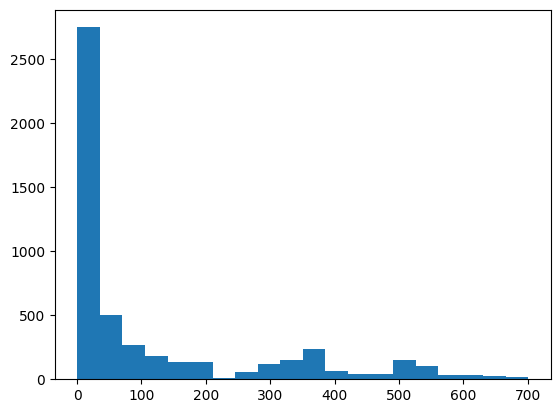

In [13]:
#normal distribuition?
for col in data.columns:
  stat, p = shapiro(data[col])
  if p > 0.05:
    print(col, ' p: ', p)

plt.hist(data['High'],bins=20)
plt.show()

In [14]:
scaler = MinMaxScaler() #StandardScaler()
data_scaled = scaler.fit_transform(data_new)
data_scaled = pd.DataFrame(data_scaled, columns=data_new.columns)
data_scaled.head(10)

,Open,High,Low,Close,Body,Candle_Size,Upper_Wick,Lower_Wick,Body_Size_long,Body_Size_medium,...,Upper_Wick_Class_long,Upper_Wick_Class_medium,Upper_Wick_Class_no wick,Upper_Wick_Class_short,Lower_Wick_Class_long,Lower_Wick_Class_medium,Lower_Wick_Class_no wick,Lower_Wick_Class_short,Direction_bearish,Direction_bullish
0,0.001125,0.001188,0.001166,0.001191,0.000727,0.001593,0.001675,0.000330,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.001209,0.001162,0.001241,0.001211,0.000078,0.000376,0.000387,0.000396,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.001208,0.001172,0.001182,0.001134,0.001025,0.001204,0.000670,0.000000,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.001137,0.001076,0.001078,0.001057,0.001103,0.001267,0.000000,0.000550,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.001055,0.000995,0.001057,0.001010,0.000662,0.000527,0.000000,0.000000,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.001013,0.000953,0.001057,0.001018,0.000039,0.000013,0.000000,0.000154,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0.001015,0.001054,0.001065,0.001093,0.000883,0.001166,0.000747,0.000110,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.001095,0.001041,0.001115,0.001078,0.000324,0.000401,0.000155,0.000220,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
8,0.001059,0.001069,0.001109,0.001120,0.000662,0.000803,0.000438,0.000110,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.001116,0.001172,0.001170,0.001171,0.000584,0.001355,0.001804,0.000044,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


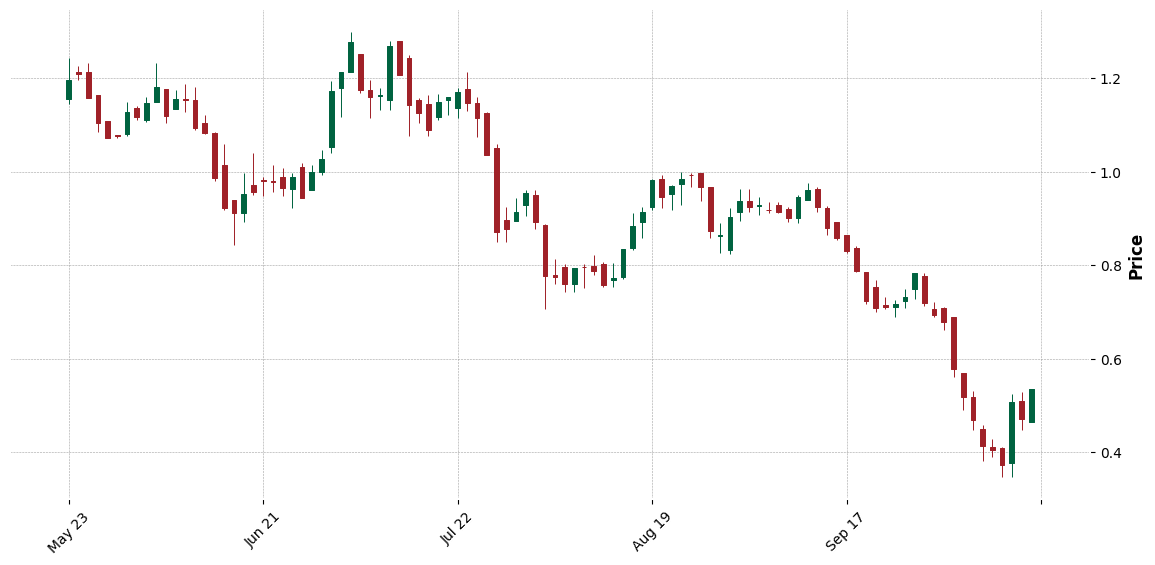

In [15]:
#mpf test
mpf.plot(data_new.set_index(data['Date']).head(100),type='candle', style='charles', figsize=(15, 7))
plt.show()

### How many types of candles?

In [16]:
wick_up = len(['l','m','s','n'])
wick_down = len(['l','m','s','n'])
body = len(['l','m','s','n'])
bull_bear = len(['bull','bear'])

n_cl = wick_up * wick_down * body * bull_bear

### Model

In [17]:
cl = KMeans(n_cl)
cl.fit(data_scaled)

KMeans(n_clusters=128)

In [18]:
data_new.set_index(data['Date'], inplace=True)
data_new['label'] = cl.labels_

### Plotting

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


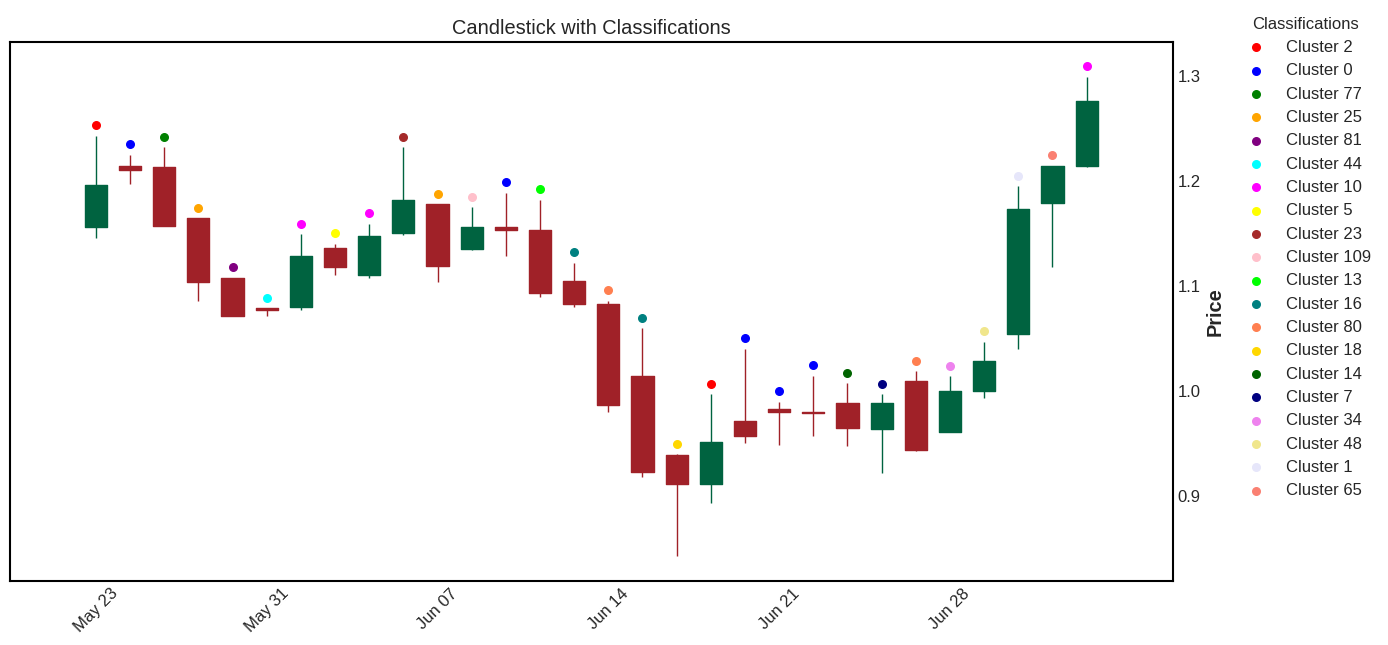

In [29]:
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt

# Defina uma lista de cores com pelo menos n_cl cores diferentes
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow',
    'brown', 'pink', 'lime', 'teal', 'coral', 'gold', 'darkgreen', 'navy',
    'violet', 'khaki', 'lavender', 'salmon', 'tomato', 'chocolate', 'lightblue',
    'darkorange', 'forestgreen', 'mediumvioletred', 'slateblue', 'mediumseagreen',
    'indigo', 'wheat', 'gray'
]

n = 30
classifications = data_new['label'].head(n).unique()  # Obter classificações únicas
plots = []

fig = mpf.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1, title='Candlestick with Classifications')

# Iterar sobre classificações únicas e cores
for cl, co in zip(classifications, colors[:len(classifications)]):
    # posição
    c_ = np.where(data_new['label'].head(n) == cl, data_new['High'].head(n) + .01, np.nan)

    scatter = mpf.make_addplot(c_, type='scatter', markersize=30, marker='o', color=co, label=f'Cluster {cl}', ax=ax)
    plots.append(scatter)

mpf.plot(data_new.iloc[:, :4].head(n), type='candle',
         addplot=plots, style='charles',
         figsize=(15, 7),
         ax=ax)

ax.set_facecolor('white')
ax.legend(loc='center left', bbox_to_anchor=(1.045, 0.6), title='Classifications')
mpf.show()


### Compare elements in the same cluster


/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


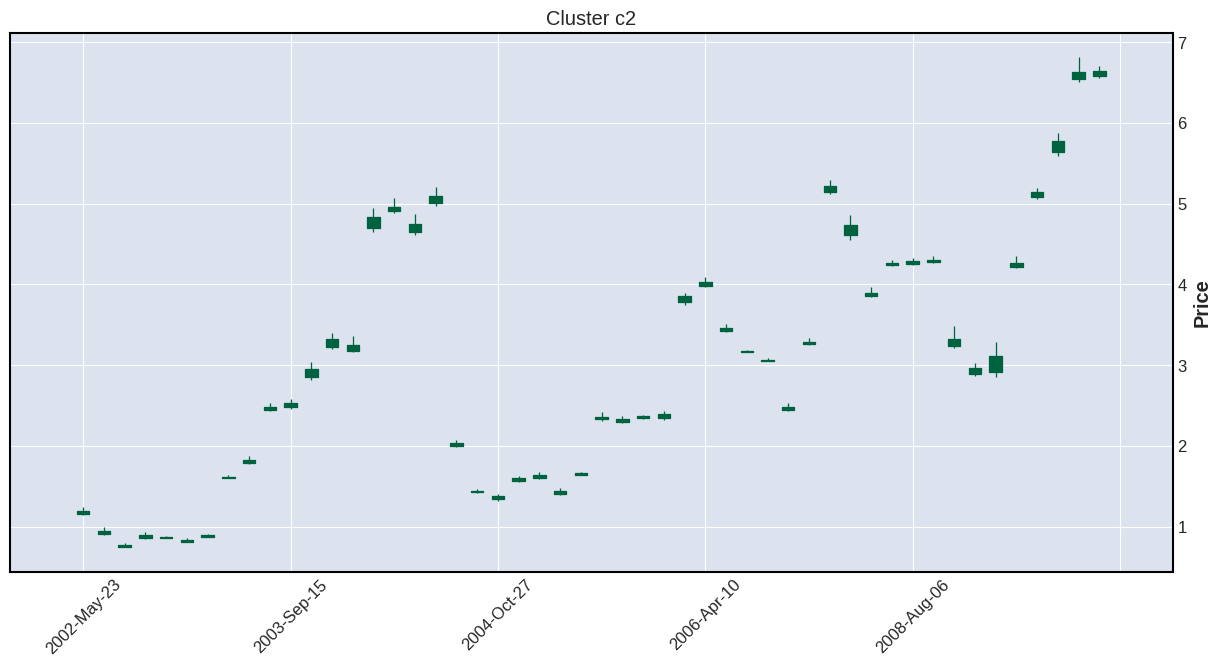

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


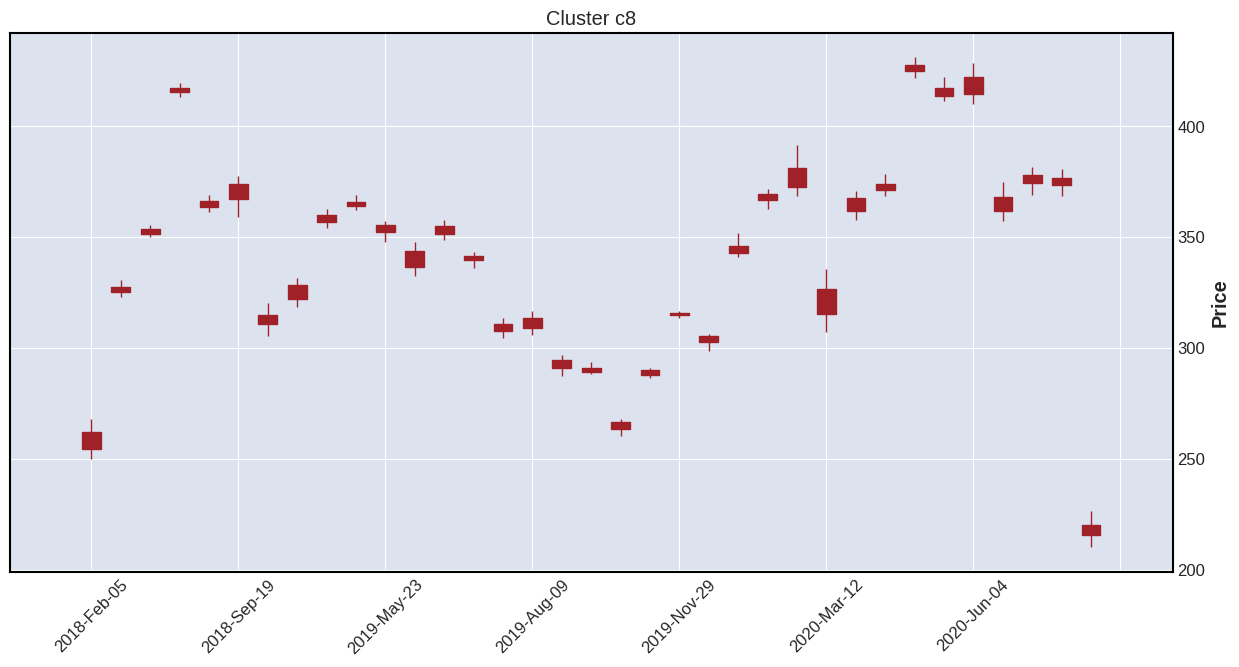

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


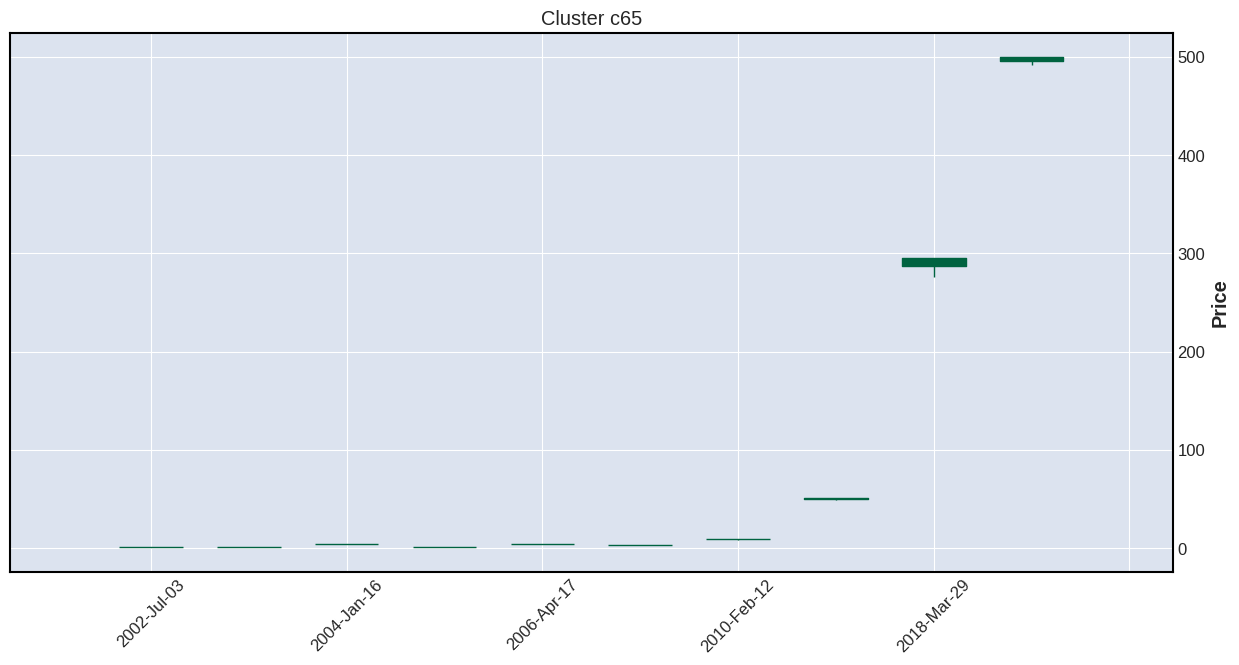

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


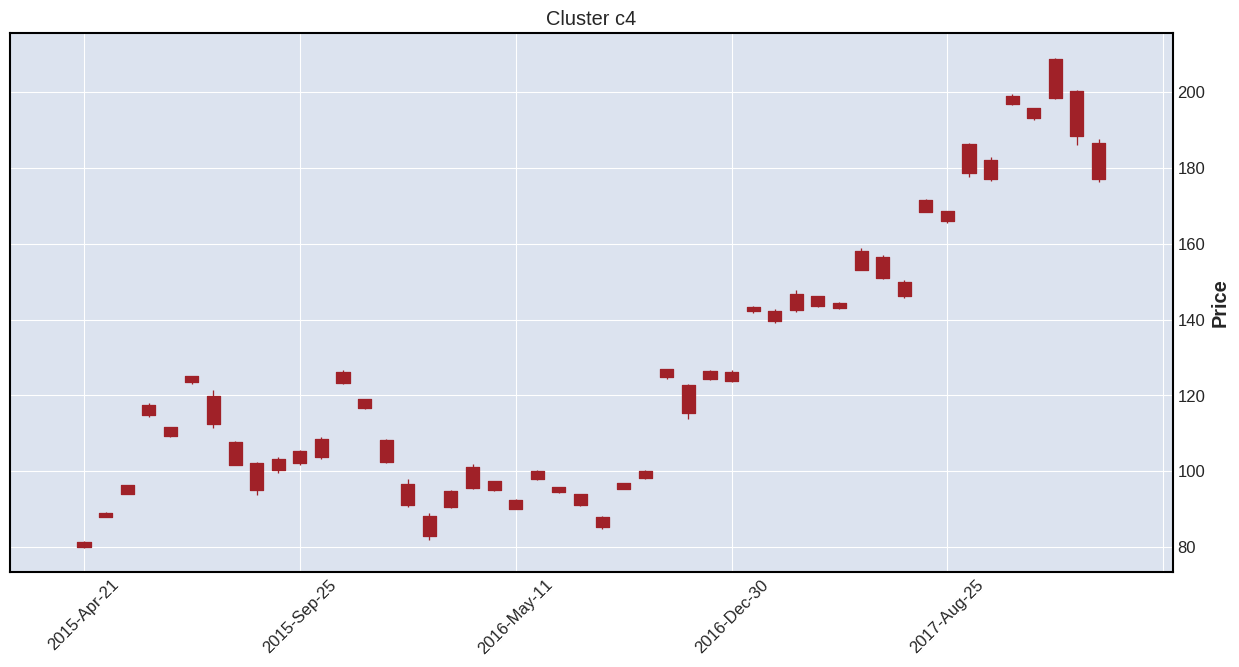

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


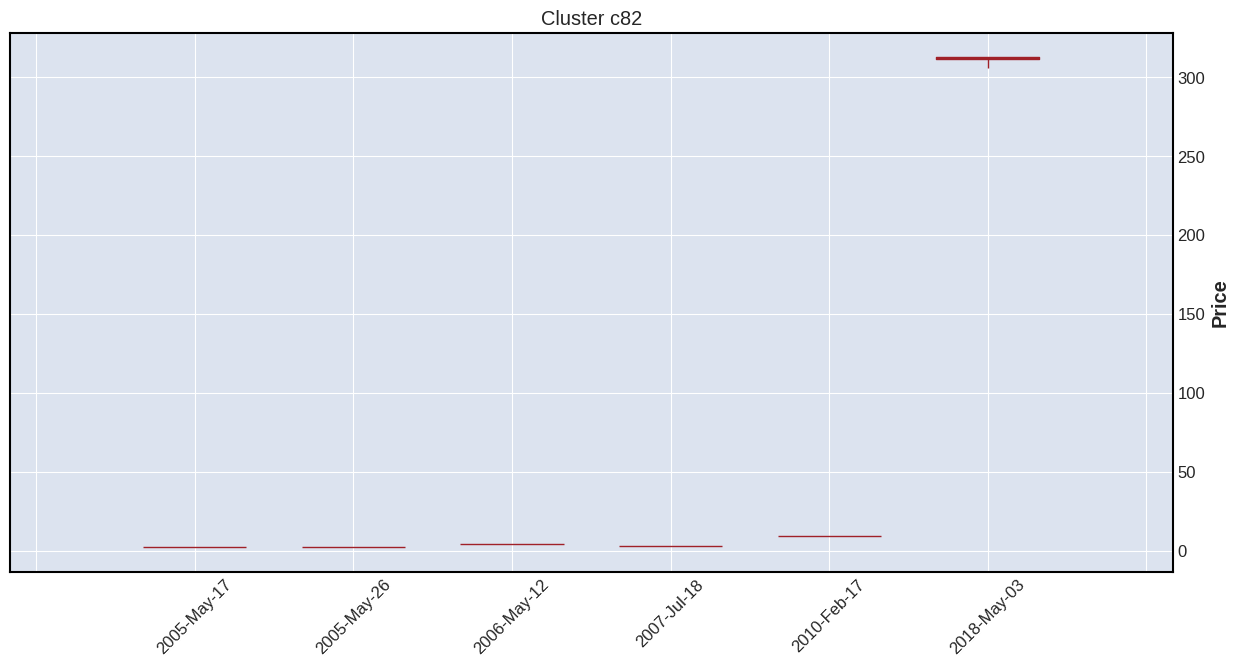

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


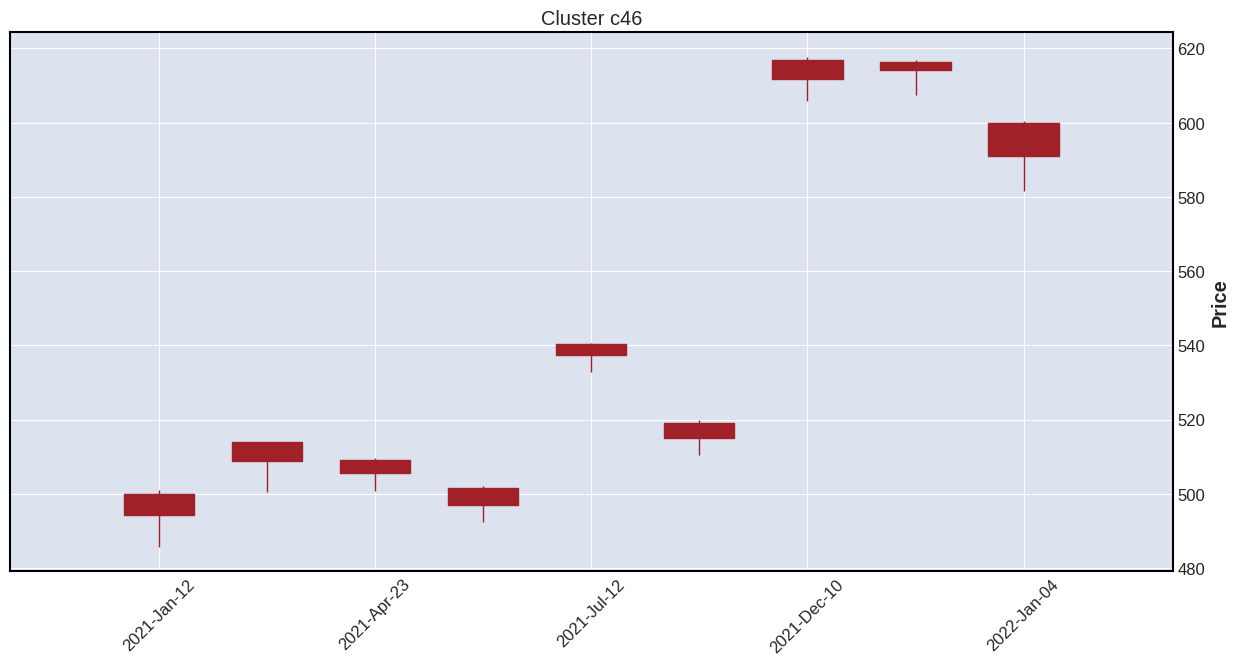

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:443: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


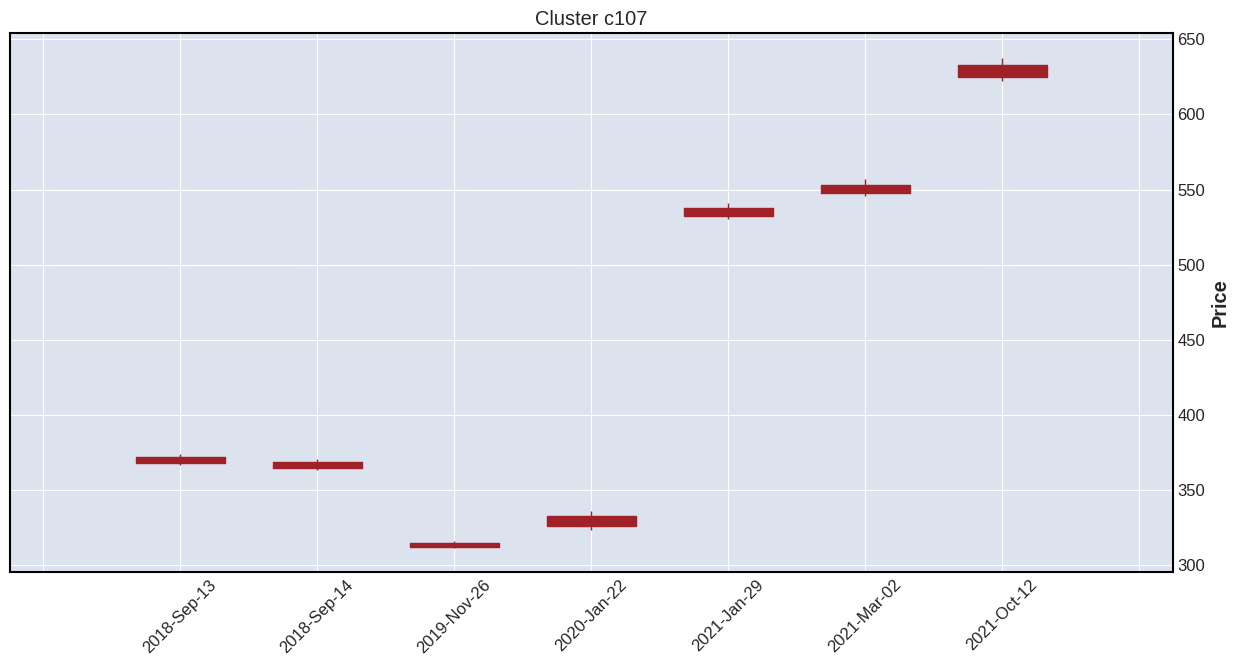

In [20]:
clusters = [2,8,65,4,82,46,107]
n = 50 #num elements

def plot_candlestick(cluster, n):
  plots = []
  fig = mpf.figure(figsize=(15, 7))
  ax = fig.add_subplot(1,1,1, title=f'Cluster c{cluster}')

  mpf.plot(data_new[data_new['label'] == cluster].iloc[:,:4].head(n), type='candle',
          addplot=plots, style='charles',
          figsize=(15, 7),
          ax=ax)
  mpf.show()

for cluster in clusters:
  plot_candlestick(cluster, n)